In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
figure(figsize=(10, 8))
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings("ignore")

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler

<Figure size 1000x800 with 0 Axes>

In [2]:
# config
root = "./data/"
allcols = ["Year", "Commodity Code", "Commodity", "Trade Value (US$)"]
cols = ["Year", "Commodity Code", "Trade Value (US$)"]

yr0 = 2000
yri = 2008
yrt = 2021
t = np.arange(yr0+1, yrt+1)

epsilon = 0.01

seed = 42

def sep(val):
    print("-"*val)

In [3]:
t

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [4]:
with open("./lists/country_names_a_m.pkl", "rb") as f:
    a_m = pickle.load(f)

with open("./lists/country_names_n_z.pkl", "rb") as f:
    n_z = pickle.load(f)

with open("./lists/country_names_a_z.pkl", "rb") as f:
    country_names = pickle.load(f)

with open("./lists/commodities.pkl", "rb") as f:
    commodities = pickle.load(f)

In [5]:
df_a_m = pd.read_excel(root + "A-M Master File(00-28).xlsx", sheet_name=a_m)
df_n_z = pd.read_excel(root + "N-Z Master File(00-28).xlsx", sheet_name=n_z)

df_a_z = dict(df_a_m)
df_a_z.update(df_n_z)

del df_a_m, df_n_z

print(len(df_a_z))

# shorten df_a_z
for country, df in df_a_z.items():
    df_a_z[country] = df[allcols]

180


### Get GDP df

In [6]:
dfs_g = pd.read_excel("./data/GDP per capita.xls", sheet_name="data")
dfs_g.index = dfs_g['Country Name'].values
dfs_g.drop(['Country Code', 'Country Name', '2022'], axis=1, inplace=True)
dfs_g.columns = pd.to_numeric(dfs_g.columns)
dfs_g.shape

(265, 22)

In [7]:
features = dfs_g.values
indexes = dfs_g.index.values

normalized_features = MinMaxScaler([-1,1]).fit_transform(features)

dfs_g_normalized = pd.DataFrame(normalized_features, columns=dfs_g.columns, index=indexes)

In [8]:
dfs_g.index.shape

(265,)

In [9]:
# get intersection of countries: df_a_z.keys() and dfs_g.index
countries = list(set(df_a_z.keys()).intersection(set(dfs_g.index)))
print(len(countries))
# df_a_z filter by countries
df_a_z = {country: df_a_z[country] for country in countries}
len(df_a_z)

133


133

In [10]:
dfs_g = dfs_g.loc[countries]
dfs_g_normalized = dfs_g_normalized.loc[countries]

dfs_g_normalized.shape

(133, 22)

### Get Trade volume df

In [11]:
def get_dfs(df_a_z, commodities, yr0, yrt):
    dfs = dict()
    t = np.arange(yr0, yrt + 1)


    for code, _ in commodities.items():
        dfs[code] = pd.DataFrame([], columns=t, index=df_a_z.keys())
        dfs[code].fillna(0, inplace=True)


    for country, df in df_a_z.items():
        for _, row in df.iterrows():
            yr, code, c, val = row
            if yr in t:
                dfs[code].loc[country, yr] = val

    for k, df in dfs.items():
        dfs[k].fillna(0, inplace=True)

    return dfs

dfs_t = get_dfs(df_a_z, commodities, yr0, yrt)

In [12]:
# filling missing values
for df in dfs_t.values():
    for c, row in df.iterrows():
        arr = row.values

        for idx in np.where(arr == 0)[0]:
            if(idx == 0 or idx == arr.size-1):
                continue
            if(arr[idx-1] == 0 or arr[idx+1] == 0):
                continue
            else:
                arr[idx] = (arr[idx-1] + arr[idx+1]) / 2

        df.loc[c] = arr

In [13]:
dfs_t_normalized = dict()

for code, df in dfs_t.items():
    features = df.values
    indexes = df.index.values
    normalized_features = MinMaxScaler([-1, 1]).fit_transform(features)

    dfs_t_normalized[code] = pd.DataFrame(normalized_features, columns=df.columns, index=indexes)    

### Cluster levels in commodity wise data

In [14]:
def get_change_cluster(c, dfs, df_g, init_params='kmeans', covariance_type='full'):
    dfs_l = dict()

    for code, dfi in dfs.items():
        dfs_l[code] = pd.DataFrame([], columns=dfi.columns)

        for year, Xt in dfi.iteritems():
            Xg = df_g[year]

            df = pd.DataFrame([], columns=['tv', 'gdp'], index=Xt.index)
            df['tv'] = Xt
            df['gdp'] = Xg

            gm = GaussianMixture(n_components=c, init_params=init_params, covariance_type=covariance_type, random_state=seed).fit(df)

            means = gm.means_
            labels = gm.predict(df)
            a = np.prod(means, axis=1)
            ranks = np.empty_like(a)
            ranks[np.argsort(a)] = np.arange(1, len(a)+1)

            new_labels = ranks[labels]
            index = df.index.values

            df_n = pd.DataFrame(new_labels, index=index, columns=[year], dtype=int)
            
            dfs_l[code][year] = df_n[year]
    return dfs_l

dfs_l = get_change_cluster(
    c=3,
    dfs=dfs_t_normalized, 
    df_g=dfs_g_normalized, 
    init_params='random', 
    covariance_type='tied'
)

In [15]:
# with pd.ExcelWriter("./cluster_level.xlsx", engine='xlsxwriter') as writer:
#     for code, df in dfs_l.items():
#         df.to_excel(writer, sheet_name=str(code), index=True)

In [16]:
def plot_commodity_change(increase, decrease, total, save=False, path=''):
    _, axes = plt.subplots(5, 4, figsize=(20, 20))

    i=0
    for (code, inc), (_, dec), (_, tot) in zip(increase.items(), decrease.items(), total.items()):
        ax = axes[i//4, i%4]
        i += 1

        ax = axes[i//4, i%4]
        i += 1

        ax.plot(t, total, marker='x', label='Total', color='r')
        ax.bar(t, increase, label='Increase', alpha=0.7, color='lightgreen')
        ax.bar(t, decrease, label='Decrease', alpha=0.7, bottom=increase, color='lightcoral')

        ax.set_xticks(np.arange(yr0+1, yrt+1, 2))
        ax.set_ylim(0, max(total)+2)
        ax.set_title(commodities[code])
        ax.set_xlabel("Year")
        ax.set_ylabel("Number of countries changing clusters level")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    if(save):
        plt.savefig(path, dpi=800, bbox_inches='tight')
    else:
        plt.show()

def plot_commodity_score(scores, save=False, path=''):
    plt.plot(t, scores, marker='x', color='r')
    plt.xticks(t)
    plt.set_title(commodities[code])
    plt.xlabel("Year")
    plt.ylabel("Silhouette Score")
    plt.grid(True)

    if(save):
        plt.savefig(path, dpi=800, bbox_inches='tight')
    else:
        plt.show()

In [17]:
def commmodity_cluster_change(dfs, dfs_labels, df_g):
    increase_dict, decrease_dict, total_dict, score_dict = dict(), dict(), dict(), dict()

    for code, df in dfs.items():
        increase = np.zeros_like(t)
        decrease = np.zeros_like(t)
        total = np.zeros_like(t)
        score = []

        for year in t:
            increase[year-yr0-1] = (df[year] > df[year-1]).sum()
            decrease[year-yr0-1] = (df[year] < df[year-1]).sum()
            total[year-yr0-1] = (df[year] != df[year-1]).sum()

            # X = dfs[code][year].values.reshape(-1, 1)
            X = pd.DataFrame({'tv': df[year].values, 'gdp': df_g[year].values}, index=df.index)

            labels = dfs_labels[code][year].values.reshape(-1, 1)
            score.append(silhouette_score(X, labels))

        increase_dict[code] = increase
        decrease_dict[code] = decrease
        total_dict[code] = total
        score_dict[code] = np.array(score)

    return increase_dict, decrease_dict, total_dict, score_dict

In [18]:
increase, decrease, total, score = commmodity_cluster_change(
    dfs=dfs_l, 
    dfs_labels=dfs_t_normalized,
    df_g=dfs_g_normalized
)

### Cluster levels in aggregate data

In [19]:
dfs_total = pd.DataFrame([], columns=np.arange(2000, 2022), index=df_a_z.keys())
dfs_total.fillna(0, inplace=True)

for _, df in dfs_t.items():
    dfs_total += df

features = dfs_total.values
indexes = dfs_total.index.values

normalized_features = MinMaxScaler([-1,1]).fit_transform(features)

dfs_total_normalized = pd.DataFrame(normalized_features, columns=dfs_total.columns, index=indexes)

dfs_total.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Argentina,10645062300,11018123507,10685570737,12835079328,14929270139,16738575932,18953597909,24838249088,31815199213,25041181582,...,38774895517,38278395237,34879343359,30643860868,32968738248,31410894350,30291982751,34523876898,31405558730,36043741268
Cambodia,53192694,52807955,56452208,53657753,78117233,74179236,78682936,82977069,178701949,126290597,...,385588825,616559103,610663857,582795325,654037364,856886638,941325140,941660164,1113334785,1382996395
Algeria,77684779,81169239,99684363,121963216,160762103,248434875,377398932,338356331,555048679,284273398,...,476778097,510938507,437406147,343916936,403050529,415356081,0,0,0,0
Malawi,341996085,393781804,330982015,443303103,385567377,413418899,572153148,775751034,789320308,1083147131,...,1100888403,1108349924,1023075793,878463062,885973185,808281391,819982113,850736412,730662381,0
Luxembourg,603228114,614997855,720902177,835068366,1006172729,1104522015,1136353952,1309796129,1454148624,1262011892,...,1709286882,1699522415,1920321909,1648893574,1497687616,1537480829,1674838638,1569095731,1555326343,1735841930


In [20]:
def aggregate_cluster_change(c, dfs, df_g, init_params='kmeans', covariance_type='full'):
    increase = np.zeros_like(t)
    decrease = np.zeros_like(t)
    total = np.zeros_like(t)
    score = []
    ds = []

    dfs_total_ll = pd.DataFrame([], columns=np.arange(2000, 2022), index=df_a_z.keys())

    for year, Xt in dfs.iteritems():
        Xg = df_g[year]
        df = pd.concat([Xt, Xg], axis=1)
        df.columns = ['tv', 'gdp']
        ds.append(df)

        gm = GaussianMixture(n_components=c, init_params=init_params, covariance_type=covariance_type, random_state=seed).fit(df)

        means = gm.means_
        labels = gm.predict(df)
        a = np.prod(means, axis=1)
        ranks = np.empty_like(a)
        ranks[np.argsort(a)] = np.arange(len(a))

        new_labels = ranks[labels]
        index = df.index.values

        df_n = pd.DataFrame(new_labels, index=index, columns=[year], dtype=int)

        # print(year, df_n[year].value_counts(), sep='\n')
        dfs_total_ll[year] = df_n[year]

    for year in t:
        increase[year-yr0-1] = (dfs_total_ll[year] > dfs_total_ll[year-1]).sum()
        decrease[year-yr0-1] = (dfs_total_ll[year] < dfs_total_ll[year-1]).sum()
        total[year-yr0-1] = (dfs_total_ll[year] != dfs_total_ll[year-1]).sum()

        # X = dfs_total_normalized[year].values.reshape(-1, 1)
        X = ds[year-yr0-1]

        labels = dfs_total_ll[year].values.reshape(-1, 1)
        score.append(silhouette_score(X, labels))

    return increase, decrease, total, np.array(score), dfs_total_ll


def plot_aggregate_change(total, increase, decrease, save=True, path=''):
    plt.plot(t, total, marker='x', label='Total', color='r')
    plt.bar(t, increase, label='Increase', alpha=0.7, color='lightgreen')
    plt.bar(t, decrease, label='Decrease', alpha=0.7, bottom=increase, color='lightcoral')

    plt.xticks(np.arange(yr0+1, yrt+1))
    plt.ylim(0, max(total)+2)
    plt.title("Aggregate Trade Value")
    plt.xlabel("Year")
    plt.ylabel("Number of countries changing clusters level")
    plt.legend()
    plt.grid(True)

    if(save):
        plt.savefig(path, dpi=800, bbox_inches='tight')
    else:
        plt.show()

def plot_aggregate_score(scores, save=True, path=''):
    plt.plot(t, scores, marker='x', color='r')
    plt.xticks(t)
    plt.title("Silhouette Score")
    plt.xlabel("Year")
    plt.ylabel("Silhouette Score")
    plt.grid(True)

    if(save):
        plt.savefig(path, dpi=800, bbox_inches='tight')
    else:
        plt.show()

In [21]:
def get_perm_labels(means, labels):
    a = np.prod(means, axis=1)
    ranks = np.empty_like(a)
    ranks[np.argsort(a)] = np.arange(1, len(a)+1)

    new_labels = ranks[labels]
    return new_labels

def calc_icd_score(X, labels, n_clusters=3):
    intra_distances = []

    for cluster_label in range(n_clusters):
            cluster_points = X[labels == cluster_label].values
            intra_distance = pairwise_distances(cluster_points).mean()
            intra_distances.append(intra_distance)

    return np.mean(intra_distances)

def plot_aggregate_decision_boundary(c, dfs, df_g, init_params='kmeans', covariance_type='full', save=False, path=''):
    xx, yy = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
    centroid_list = []
    icd_scores = []

    fig, axes = plt.subplots(5, 5, figsize=(20, 20))

    def get_Z(model):
        means = model.means_
        labels = gm.predict(np.c_[xx.ravel(), yy.ravel()])
        centroid_list.append(means)

        return get_perm_labels(means, labels).reshape(xx.shape)

    i = 0
    for year, Xt in dfs.iteritems():
        Xg = df_g[year]

        df = pd.DataFrame([], columns=['tv', 'gdp'], index=Xt.index)
        df['tv'] = Xt*1
        df['gdp'] = Xg*1
        df = df.loc[~df['gdp'].isna()]

        gm = GaussianMixture(n_components=c, covariance_type=covariance_type, init_params=init_params, random_state=42).fit(df)
        Z = get_Z(gm)

        icd_scores.append(calc_icd_score(df, gm.predict(df), c))
        # icd_scores.append(1)

        ax = axes[i//5, i%5]
        i += 1

        ax.contourf(xx, yy, Z, alpha=0.8)
        ax.scatter(df['tv'], df['gdp'], marker='o', color='black', edgecolors='w', s=50)
        ax.set_title(f'Year:{year}')
        ax.set_xlabel('tv')
        ax.set_ylabel('gdp')
        ax.grid(True)

    fig.suptitle(f'Decision Boundary {c} clusters', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.99])

    if(save):
        plt.savefig(path, dpi=800, bbox_inches='tight')
    else:
        plt.show()

        
    return centroid_list, icd_scores

In [22]:
c = 3
dfs = dfs_total_normalized.copy()
df_g = dfs_g_normalized.copy()
init_params = 'random'
covariance_type = 'tied'

increase, decrease, total, scores, _  = aggregate_cluster_change(
    c=c,
    dfs=dfs, 
    df_g=df_g,
    # init_params=init_params,
    # covariance_type=covariance_type
)

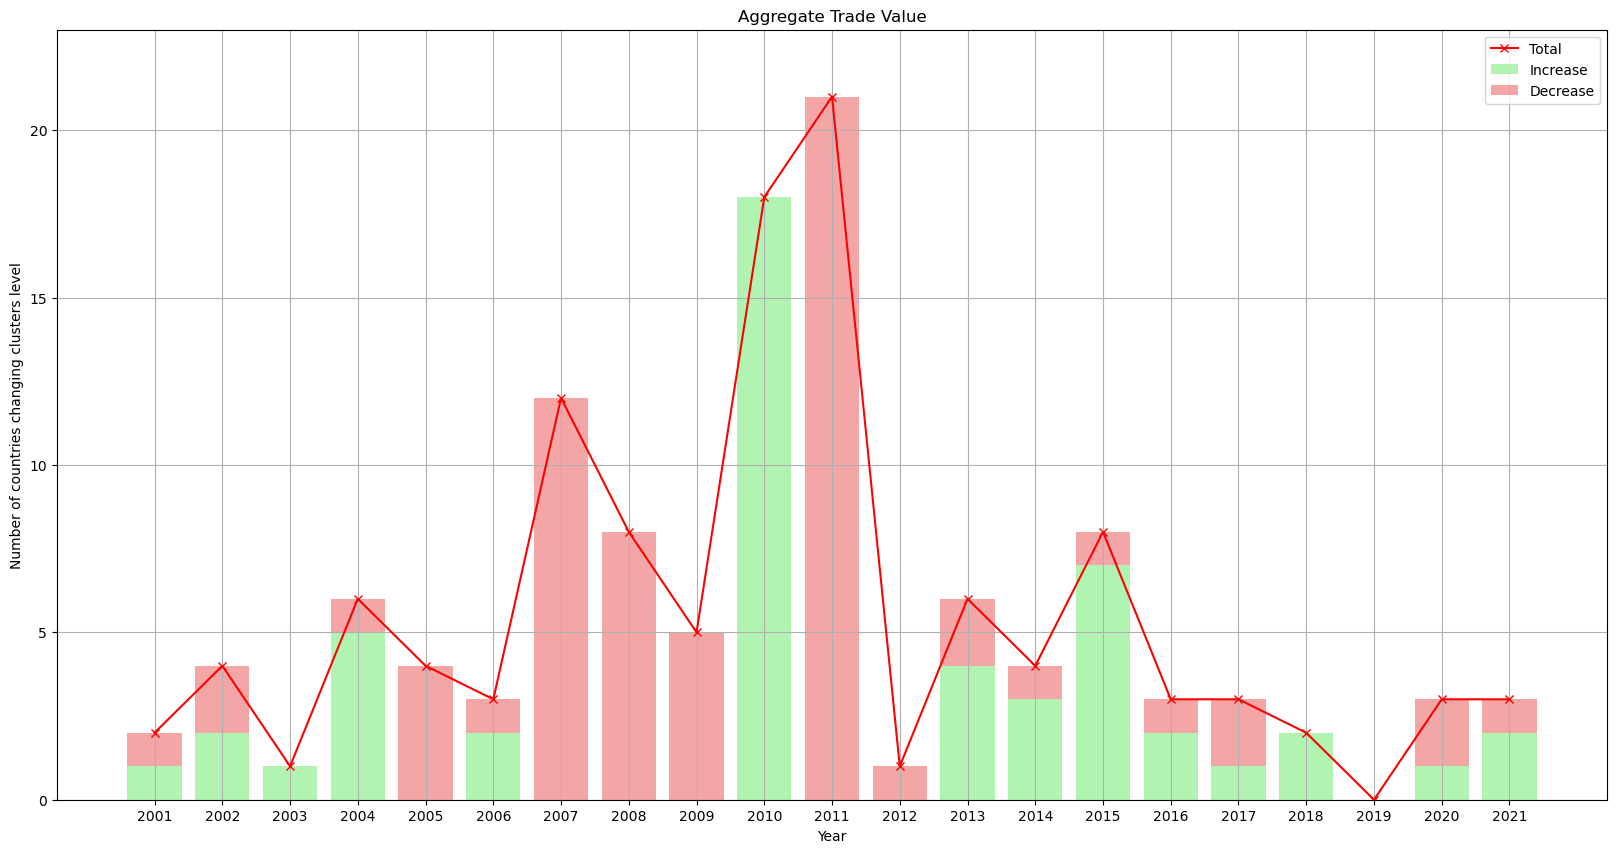

In [23]:
plot_aggregate_change(total, increase, decrease, save=False)

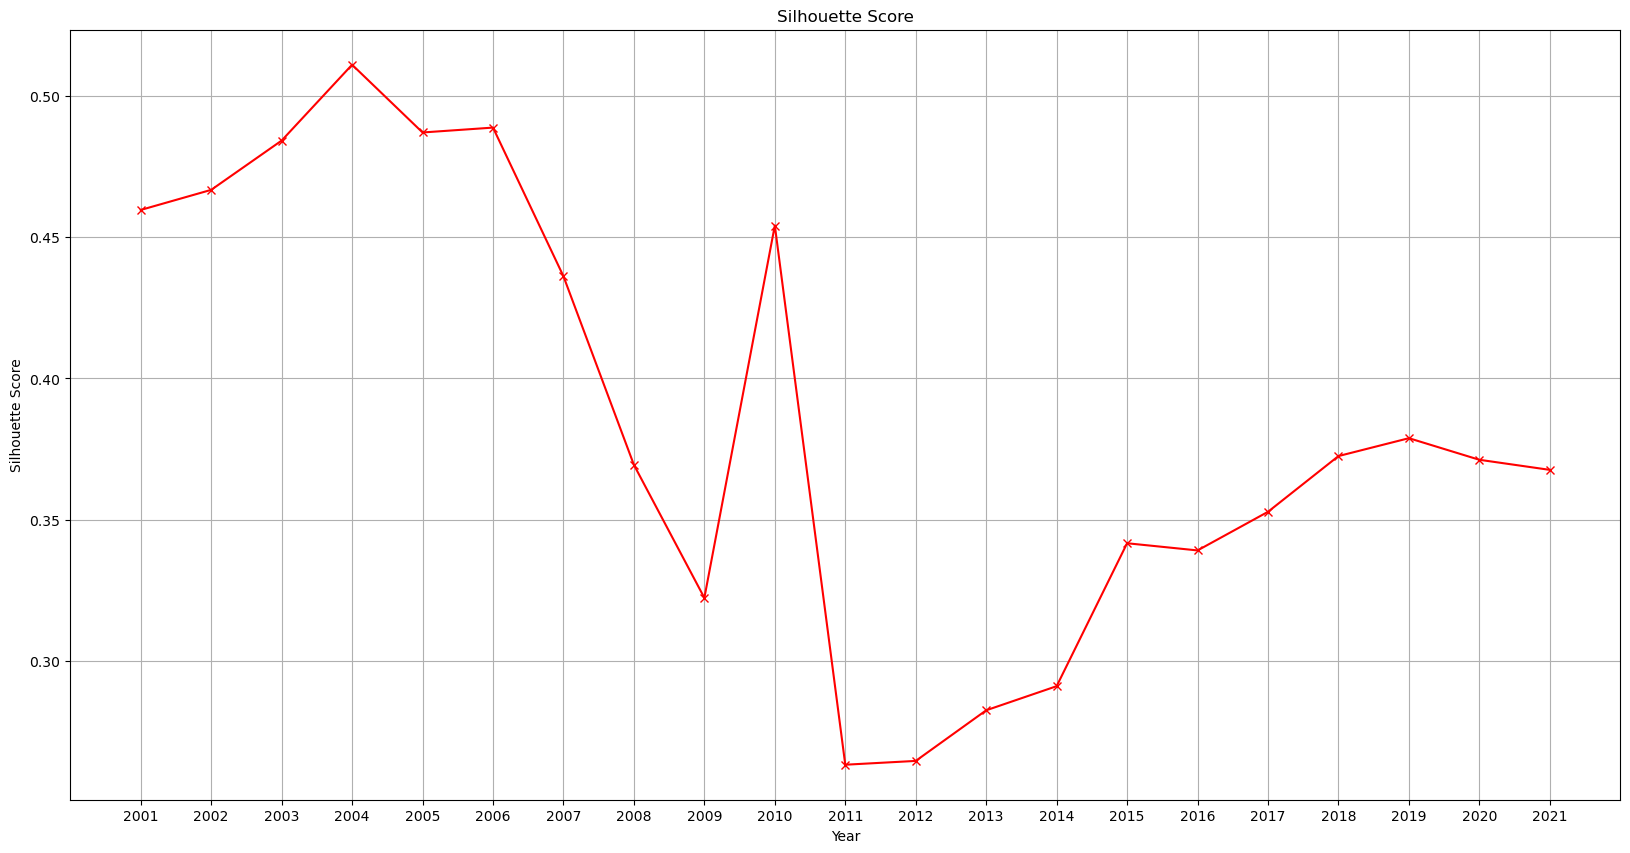

In [24]:
plot_aggregate_score(scores, save=False)

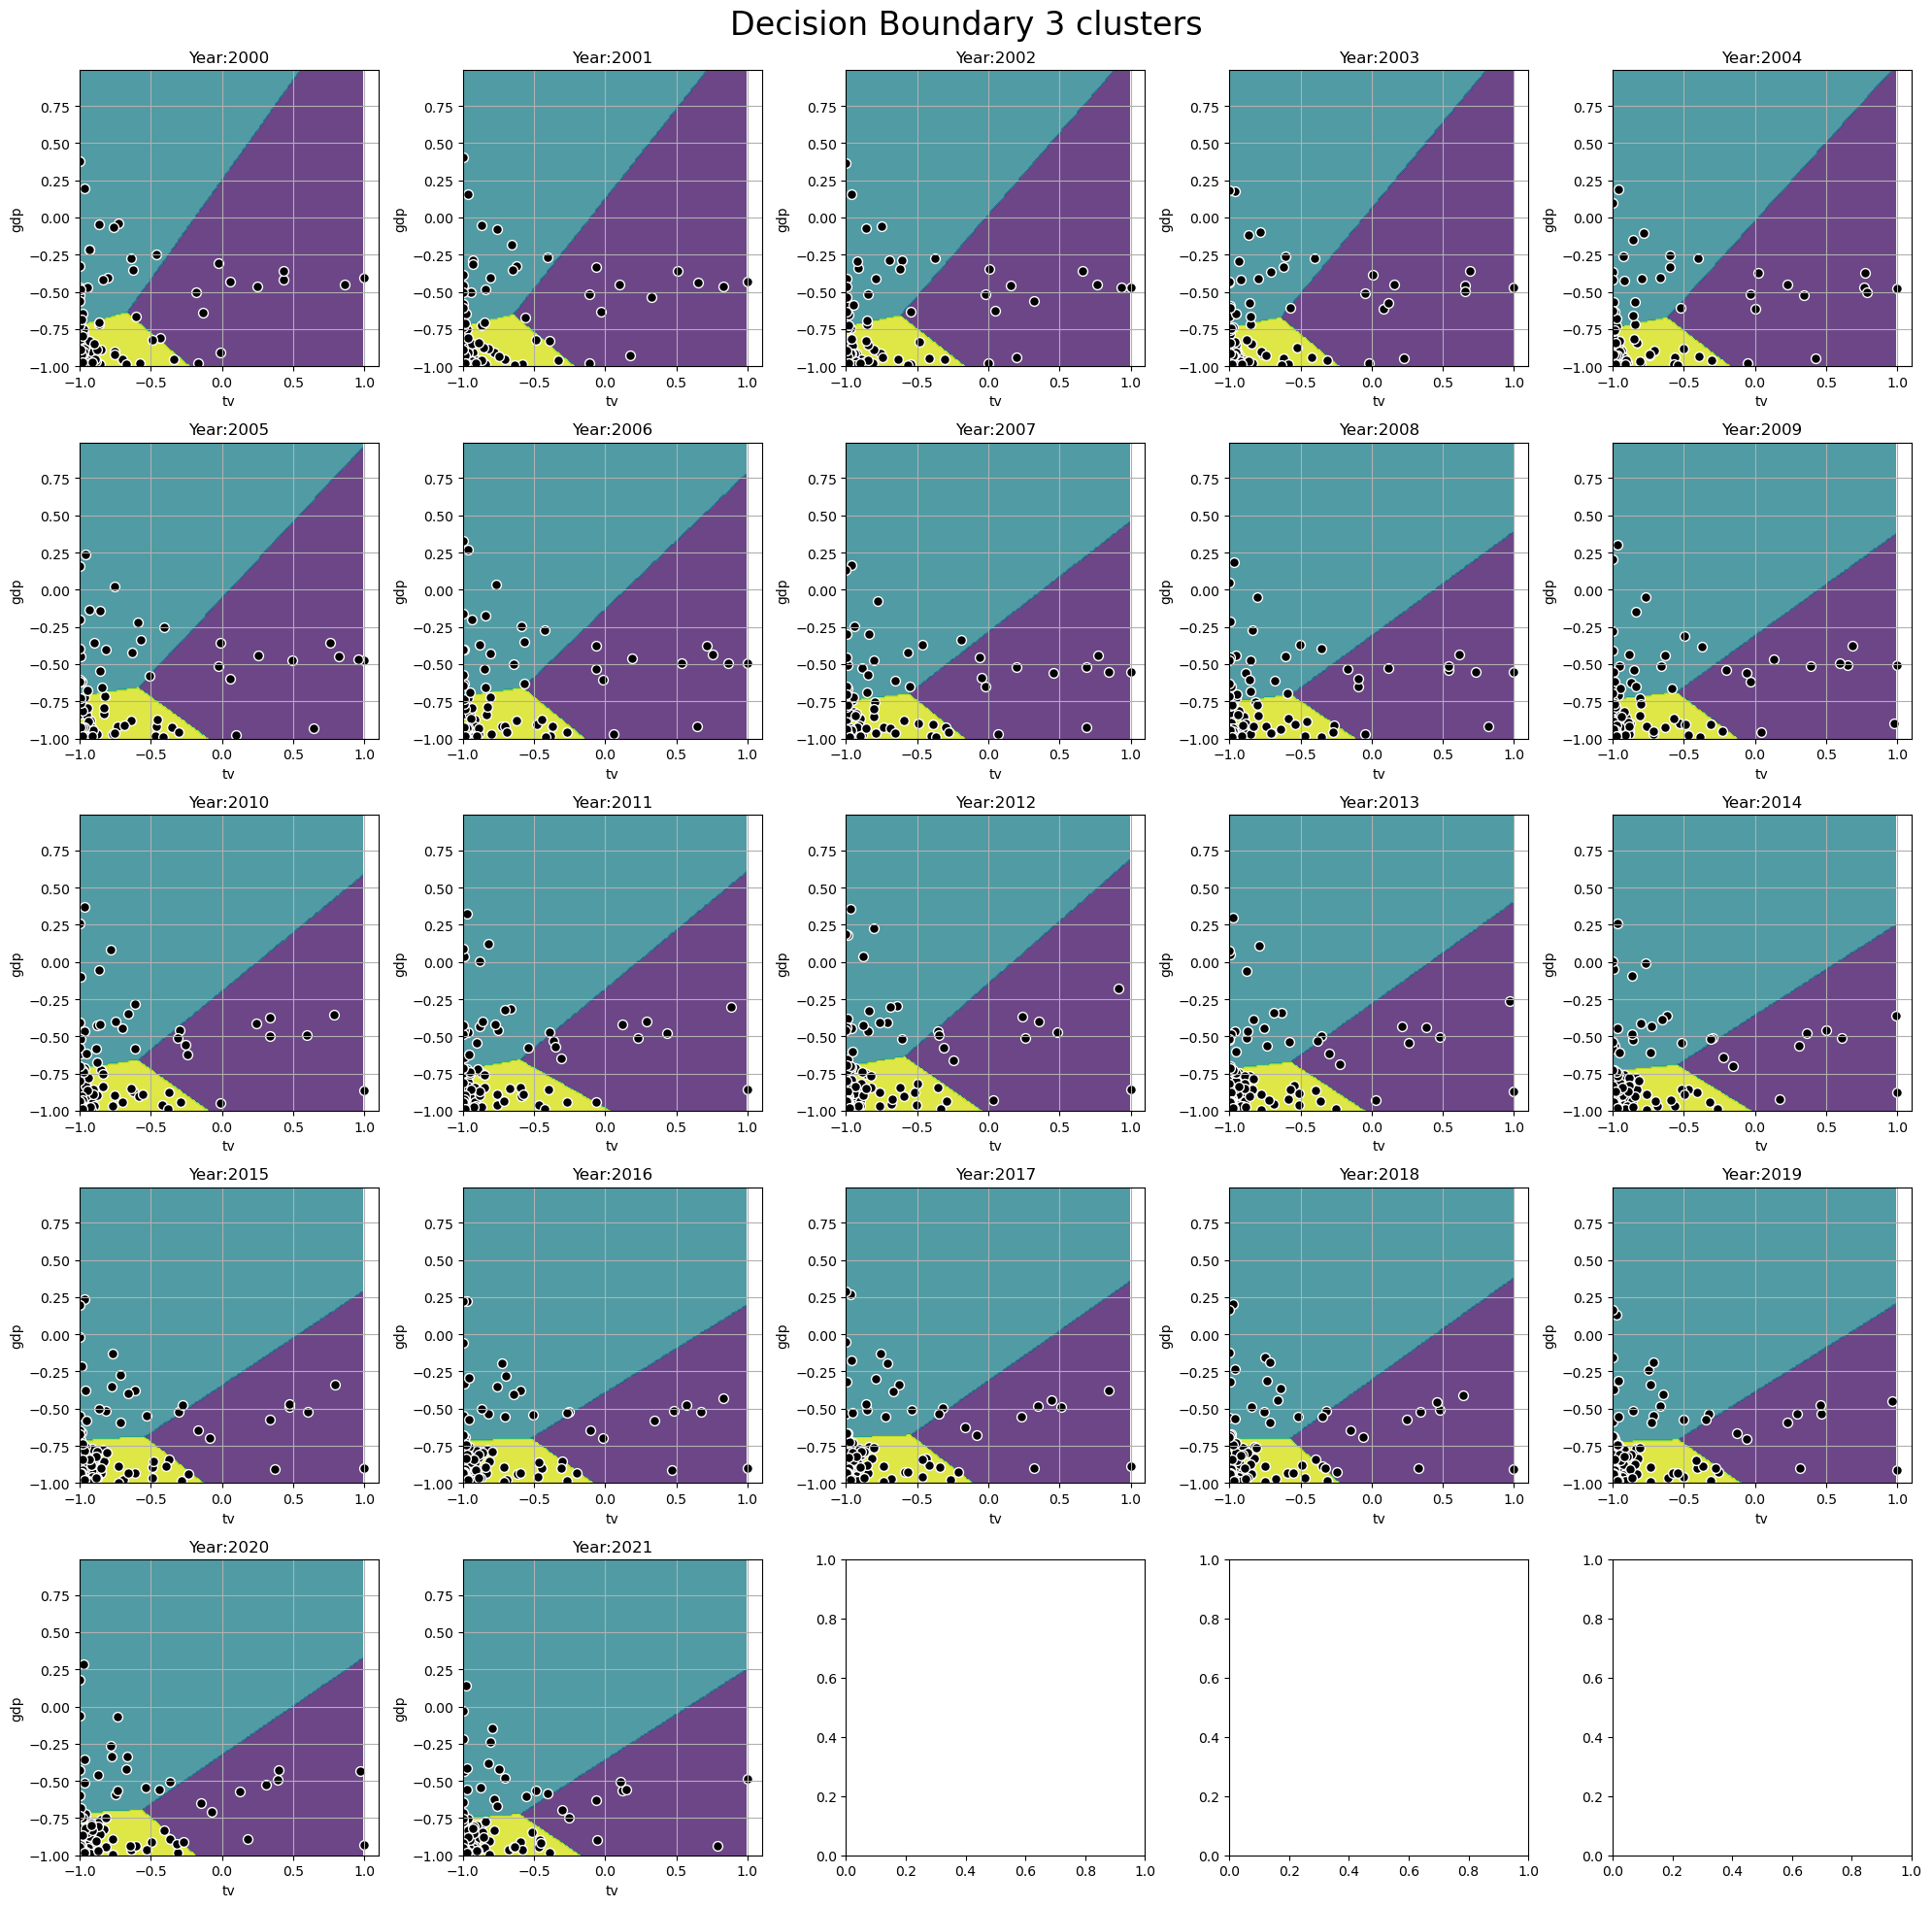

22 22


In [26]:
centroid_list, icd_scores = plot_aggregate_decision_boundary(
    c=c,
    dfs=dfs,
    df_g=df_g,
    init_params=init_params,
    covariance_type=covariance_type,
    save=False
)

print(len(centroid_list), len(icd_scores))

In [27]:
trace_c1, trace_c2, trace_c3 = [], [], []
trace_c1_t, trace_c1_g = [], []
trace_c2_t, trace_c2_g = [], []
trace_c3_t, trace_c3_g = [], []

for c1, c2, c3 in centroid_list:
    trace_c1.append(c1)
    trace_c2.append(c2)
    trace_c3.append(c3)

    trace_c1_t.append(c1[0])
    trace_c1_g.append(c1[1])

    trace_c2_t.append(c2[0])
    trace_c2_g.append(c2[1])

    trace_c3_t.append(c3[0])
    trace_c3_g.append(c3[1])


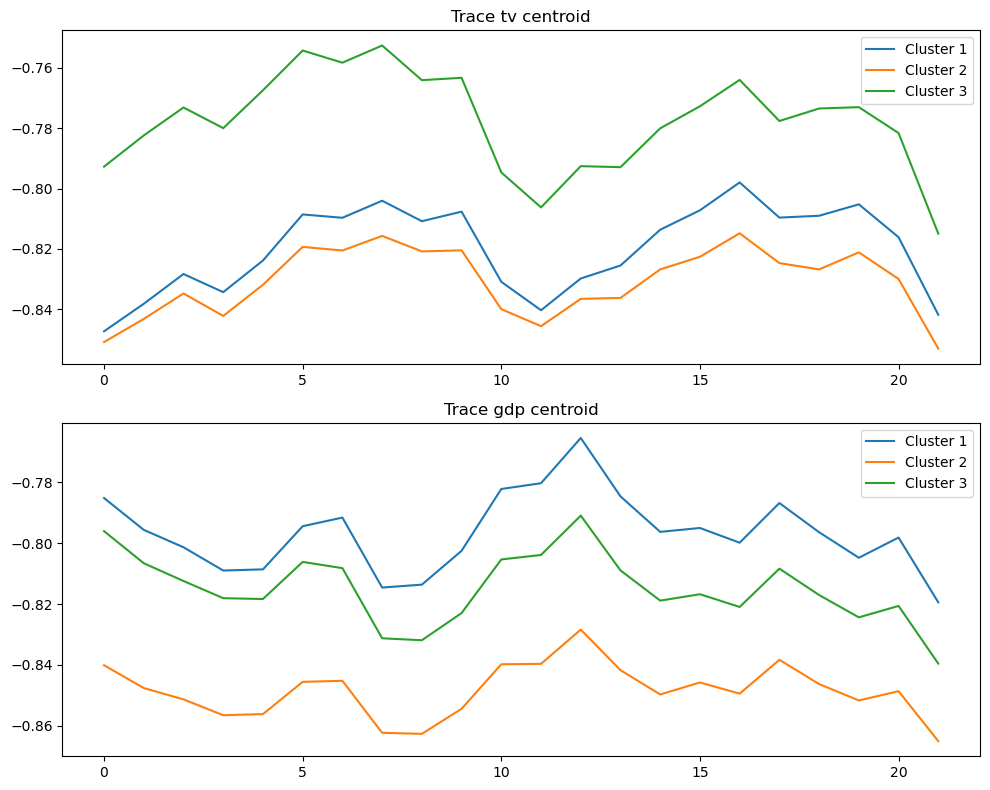

In [33]:
fig, (ax_t, ax_g) = plt.subplots(2, 1, figsize=(10, 8))

# Plot tv centroids
ax_t.plot(trace_c1_t, label='Cluster 1')
ax_t.plot(trace_c2_t, label='Cluster 2')
ax_t.plot(trace_c3_t, label='Cluster 3')
ax_t.set_title('Trace tv centroid')
ax_t.legend()

# Plot gdp centroids
ax_g.plot(trace_c1_g, label='Cluster 1')
ax_g.plot(trace_c2_g, label='Cluster 2')
ax_g.plot(trace_c3_g, label='Cluster 3')
ax_g.set_title('Trace gdp centroid')
ax_g.legend()

plt.tight_layout()
plt.show()

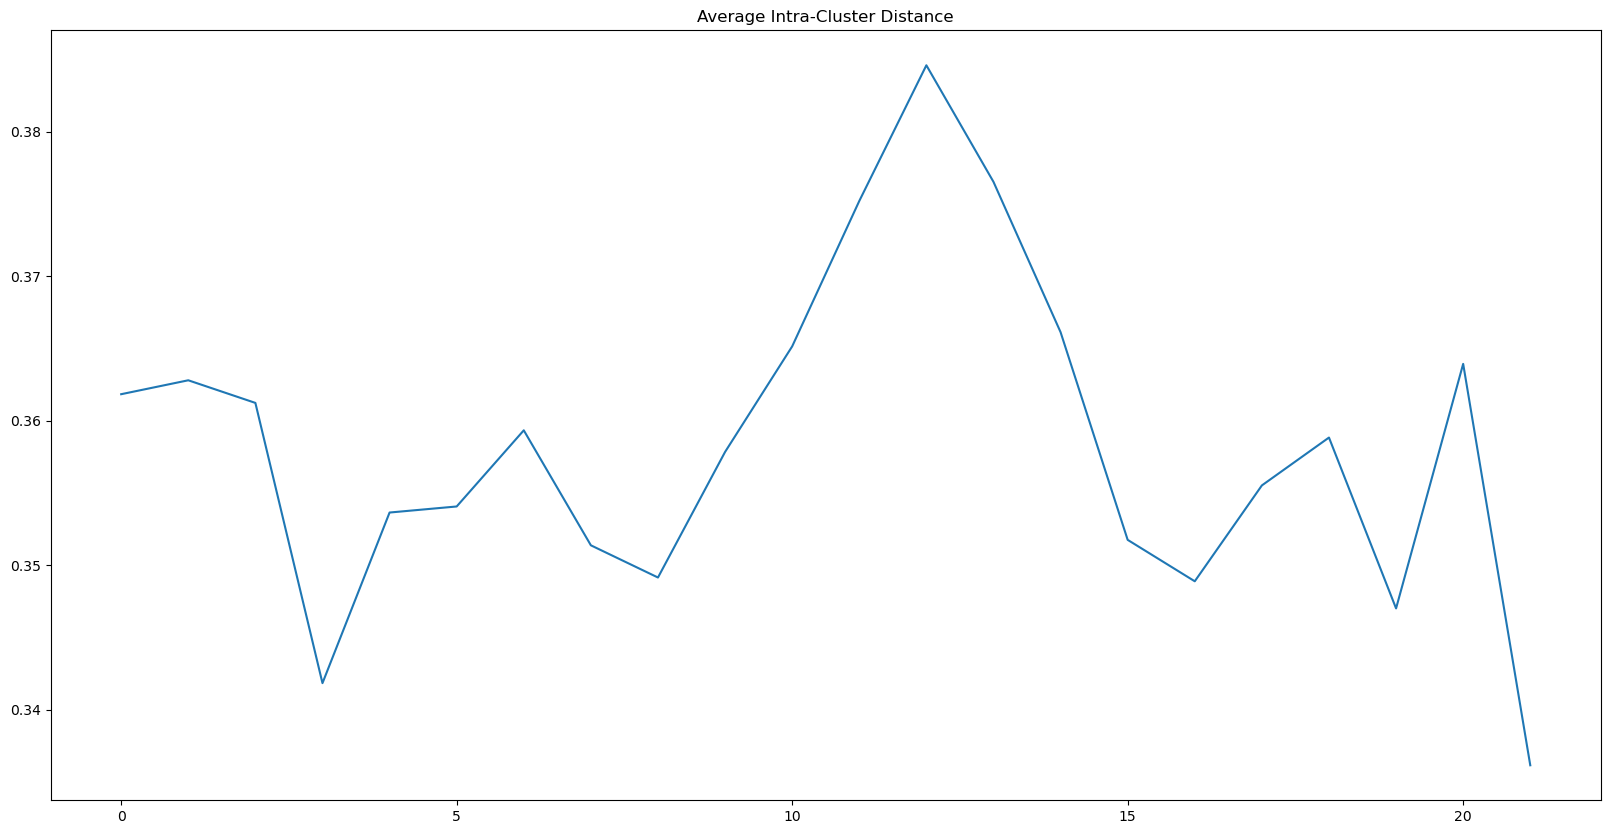

In [30]:
plt.plot(icd_scores)
plt.title('Average Intra-Cluster Distance')
plt.show()

In [31]:
# granger causality 

### Trials

In [32]:
a = np.array([
    [1, 2, 3],
    [4, 5, 6]
])
a.sum(axis=0)

array([5, 7, 9])

In [20]:
X = np.array([
    [1, 2],
    [3, 4],
    [5, 6],
    [7, 8],
    [9, 10],
    [11, 12],
    [13, 14],
    [15, 16],
    [17, 18],
    [19, 20]
])
y = np.array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2])

g = GaussianMixture(n_components=3, random_state=0).fit(X)

In [21]:
a = np.prod(g.means_, axis=1)
ranks = np.empty_like(a)
ranks[np.argsort(a)] = np.arange(len(a))
print(ranks)

y_ = ranks[y]
print(y)
print(y_)

[1. 2. 0.]
[0 0 0 0 1 1 1 2 2 2]
[1. 1. 1. 1. 2. 2. 2. 0. 0. 0.]


In [202]:
a = {1:'a', 2:'b'}
b = {1:'c', 2:'d'}
c = {1:'e', 2:'f'}

for ai, bi, ci in zip(a.items(), b.items(), c.items()):
    print(ai, bi, ci)

(1, 'a') (1, 'c') (1, 'e')
(2, 'b') (2, 'd') (2, 'f')
